**Quanvolutional Neural Networks**

A Quantum Neural Network (QNN) is a type of neural network that leverages the principles of quantum computing to enhance the performance of traditional machine learning models. It combines quantum computing techniques with classical neural networks, aiming to take advantage of quantum mechanics' properties, such as superposition, entanglement, and quantum parallelism.

**Import statements**

In [6]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from silence_tensorflow import silence_tensorflow
silence_tensorflow()


**Load and Preprocess MNIST Dataset**

1. In this code, we're preparing a smaller subset of the MNIST dataset for quick experimentation.
2. The MNIST dataset, which consists of 28x28 pixel grayscale images of handwritten digits, is typically large with 60,000 training images and 10,000 test images.
3. To make the dataset more manageable, we reduce its size by selecting only the first 60 images and their labels for training, and the first 40 images and their labels for testing. This is done by slicing the arrays accordingly.
4. The number of epochs is set to 60, which determines how many times the model will iterate over the training data during training.

In [7]:
# Load and preprocess MNIST dataset
n_train = 60    # Size of the train dataset
n_test = 40     # Size of the test dataset
n_epochs = 60

mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

# Reduce dataset size
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

# Normalize pixel values within 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add extra dimension for convolution channels
x_train = np.expand_dims(x_train, axis=-1)  # (n_train, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # (n_test, 28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Feature Reduction**
1.Flattening the Images: The function flattens each image in the dataset. For example, if you have 28x28 pixel images, flattening them will convert each image into a 784-dimensional vector.
2.Selecting Features: After flattening, the function selects only the first 4 features from these flattened vectors. This is done to reduce the dimensionality to match the requirements of your quantum circuit.


In [8]:
import numpy as np

def feature_reduction(x):
    """
    Reduces the feature dimension of the input data by flattening images and selecting only the first 4 features.

    Args:
    x (np.ndarray): Input data, expected to be a 4D array of shape (num_samples, height, width, channels).

    Returns:
    np.ndarray: Reduced feature data of shape (num_samples, 4).
    """
    # Flatten each image in the dataset
    x_flattened = x.reshape(x.shape[0], -1)  # Reshape to (num_samples, height*width*channels)

    # Select only the first 4 features
    x_reduced = x_flattened[:, :4]  # Select first 4 features

    return x_reduced

# Example usage with x_train and x_test
x_train_reduced = feature_reduction(x_train)
x_test_reduced = feature_reduction(x_test)


**One-Hot Encoding**

1. Labels are converted to a one-hot format suitable for classification tasks, where each label is represented as a vector of length 10.

In [9]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)  # Ensure shape is (n_train, 10)
y_test = to_categorical(y_test, 10)    # Ensure shape is (n_test, 10)


**Define Quantum Circuit**

The qnn_circuit function defines a quantum neural network circuit that encodes classical input features into quantum states using the AngleEmbedding template, applies parameterized entangling gates with BasicEntanglerLayers, and then measures the expectation value of the Pauli-Z operator on the first qubit. This quantum circuit is designed for tasks such as classification, where the weights are optimized to improve performance based on the measurement outcomes.

In [11]:
# Define a quantum circuit
def qnn_circuit(inputs, weights):
    qml.templates.AngleEmbedding(features=inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return qml.expval(qml.PauliZ(0))


**Create Quantum Device**

1. A quantum device with 4 qubits is created using PennyLane’s default simulator.

In [12]:
# Create a quantum device
dev = qml.device("default.qubit", wires=4)


**Define Custom Keras Layer for Quantum Computation**
1. In this section, we created a custom TensorFlow Keras layer, QuantumLayer, to integrate a quantum circuit into a neural network.
2. We initialized trainable weights for the quantum circuit, converted inputs and weights to TensorFlow tensors, and defined a quantum node to process the data through the quantum circuit.
3. Finally, we reshaped the output to match the required format. This setup allows incorporating quantum computations into a standard Keras model for hybrid quantum-classical machine learning tasks.

In [13]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        # Initialize weights as trainable parameters
        self._weights = self.add_weight(
            shape=(4, 4),  # Adjust shape to match the circuit requirements
            initializer='random_normal',
            trainable=True,
            name='quantum_weights'
        )

    def call(self, inputs):
        # Ensure inputs are in the correct shape and type
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        weights = tf.convert_to_tensor(self._weights, dtype=tf.float32)

        # Define a quantum node
        @qml.qnode(dev, interface='tf')
        def quantum_node(inputs, weights):
            return qnn_circuit(inputs, weights)

        # Get results from quantum node
        result = quantum_node(inputs, weights)

        # Convert the result back to a TensorFlow tensor and ensure correct shape
        return tf.reshape(result, (-1, 1))  # Ensure output shape is [batch_size, 1]


**Define and Compile the Model**
1. Optimizer: Adam, for optimizing the model’s weights.
2. Loss Function: Categorical crossentropy, for multi-class classification.
3. Metrics: Accuracy, to evaluate model performance.

In [14]:
# Define the model
def create_qnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(4,)),  # Adjust input shape to match feature reduction
        QuantumLayer(),
        tf.keras.layers.Dense(10, activation='softmax')  # Dense layer expects shape [batch_size, 10]
    ])
    return model

# Create and compile the model
model = create_qnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**Train and Evaluate the Model**

1. Training: The model is trained for a specified number of epochs with a batch size of 4 and a validation split of 20%.
2. Evaluation: The model is evaluated on the test set to obtain accuracy.

In [21]:
# Train the model and save history
history = model.fit(x_train_reduced, y_train, epochs=n_epochs, batch_size=4, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_reduced, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0681 - loss: 2.3249 - val_accuracy: 0.1667 - val_loss: 2.3323
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1047 - loss: 2.2755 - val_accuracy: 0.1667 - val_loss: 2.3321
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1631 - loss: 2.2582 - val_accuracy: 0.1667 - val_loss: 2.3301
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1377 - loss: 2.2905 - val_accuracy: 0.1667 - val_loss: 2.3287
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1063 - loss: 2.3354 - val_accuracy: 0.1667 - val_loss: 2.3284
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1783 - loss: 2.2896 - val_accuracy: 0.1667 - val_loss: 2.3283
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0898 - loss: 2.3217 - val_accuracy: 0.1667 - val_loss: 2.3263
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1567 - loss: 2.2516 - val_accuracy: 0.1667 - v

**Plot Training and Validation Metrics**
1. The training and validation loss and accuracy are plotted to visualize the model’s performance over epochs.

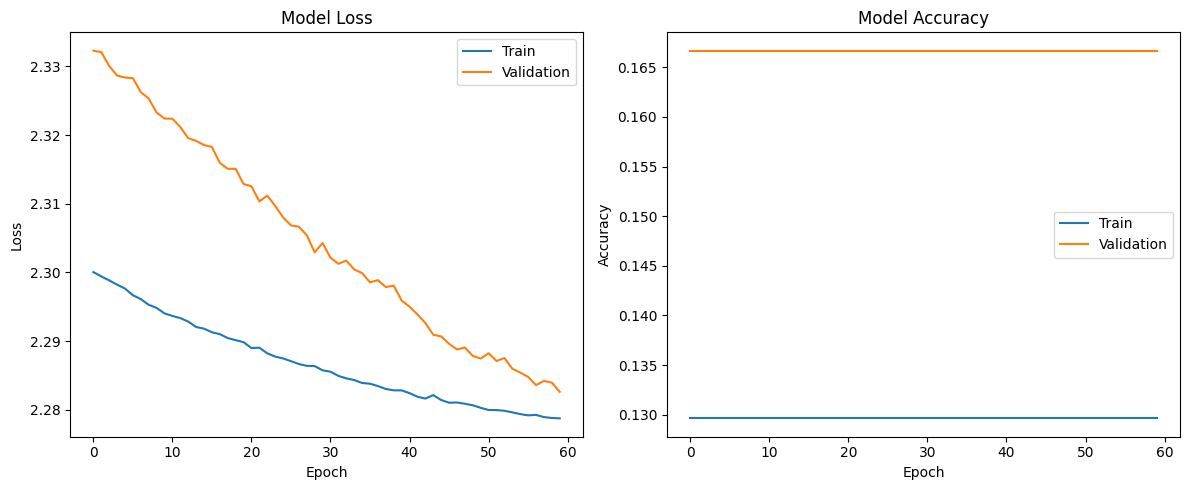

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()
